In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Canny Edge, Laplacian, LOG

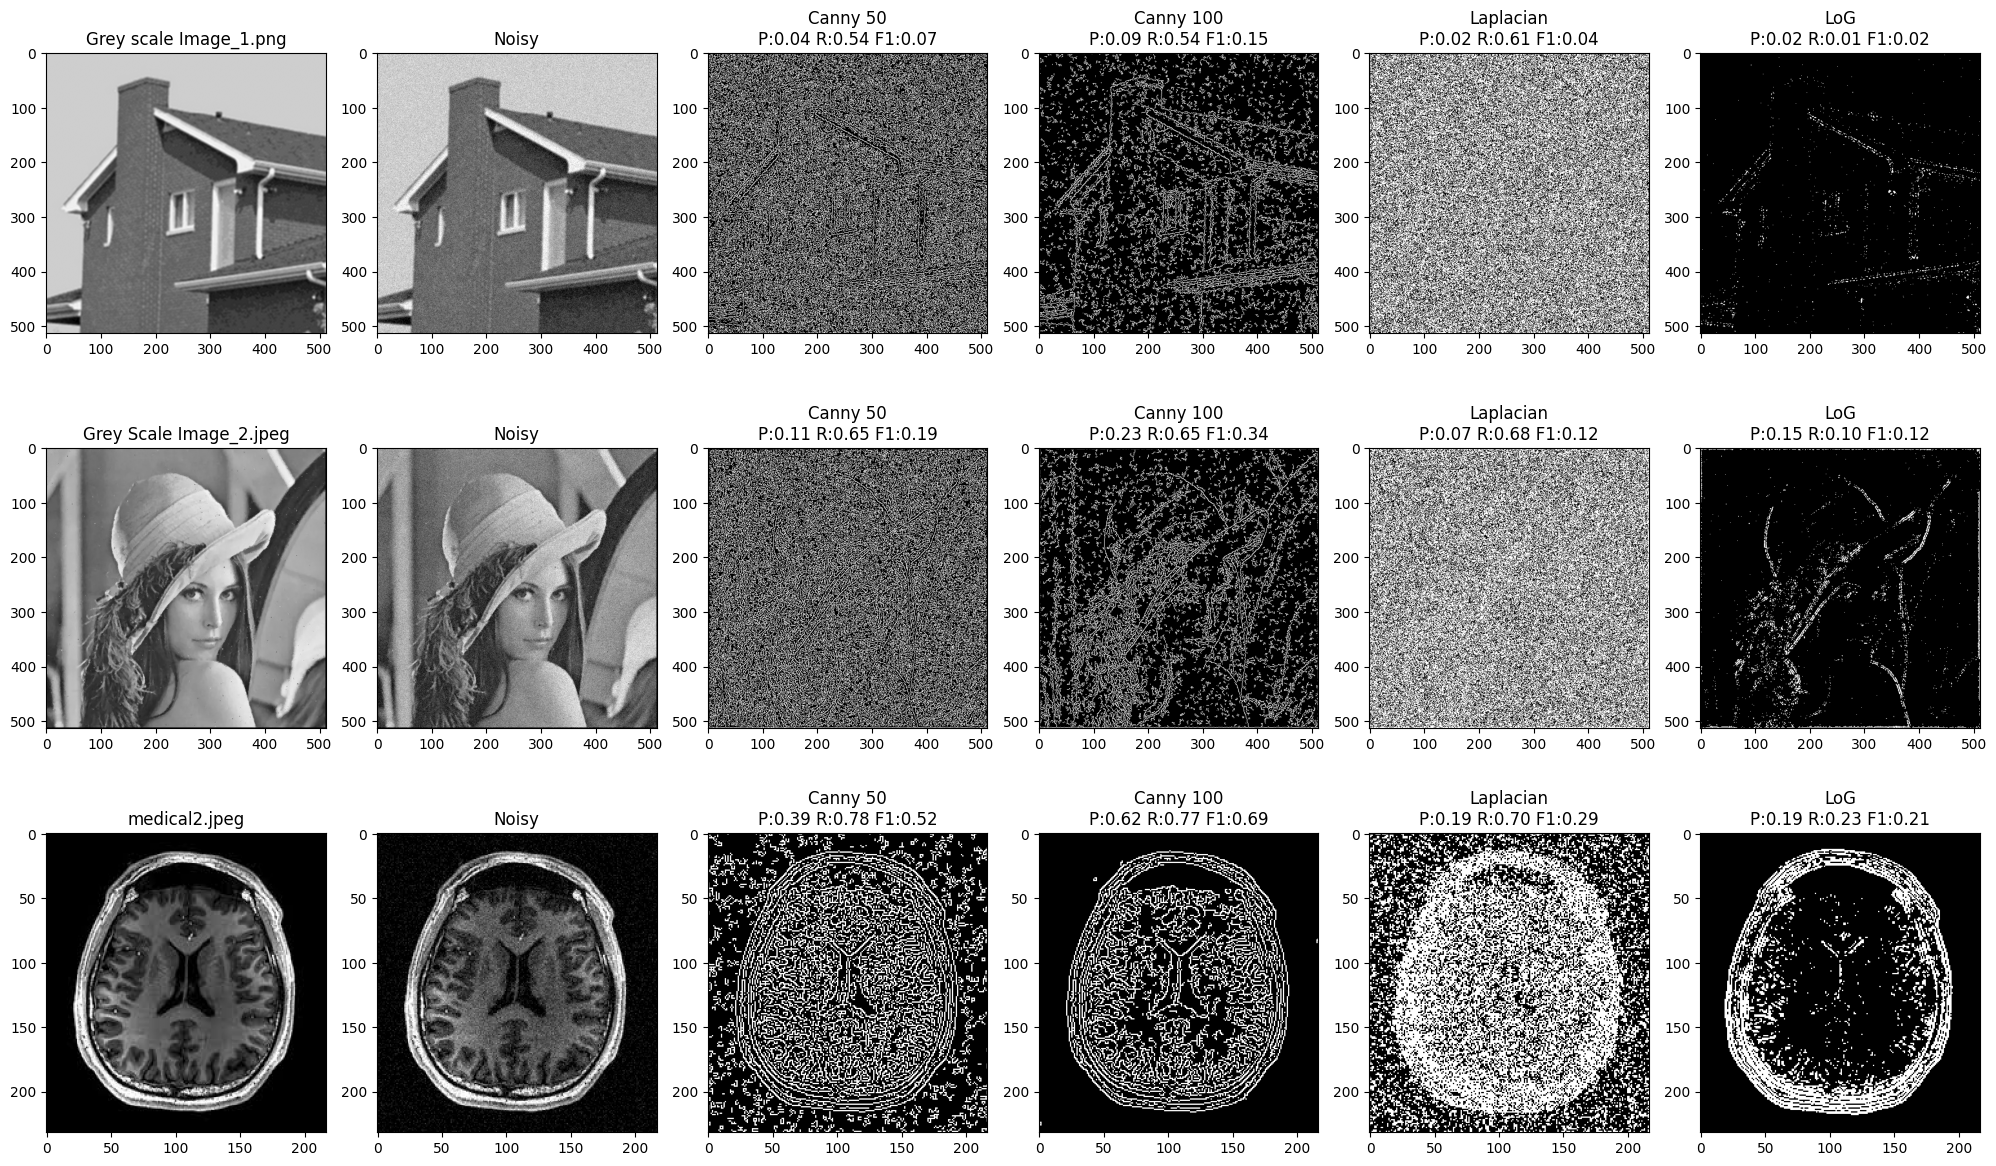

In [5]:
file_list = ['Grey scale Image_1.png', 'Grey Scale Image_2.jpeg', 'medical2.jpeg']
fig, axes = plt.subplots(len(file_list), 6, figsize=(20, 12))

for i, fname in enumerate(file_list):
    orig = cv2.imread(fname, 0)

    gt_edges = cv2.Canny(orig, 100, 200)
    gt_edges = (gt_edges > 0).astype(np.uint8)

    mean, sigma = 0, 15
    gauss = np.random.normal(mean, sigma, orig.shape).astype('float32')
    noisy = np.clip(cv2.add(orig.astype('float32'), gauss), 0, 255).astype('uint8')

    canny50 = cv2.Canny(noisy, 50, 100)
    canny100 = cv2.Canny(noisy, 100, 200)

    lap = cv2.Laplacian(noisy, cv2.CV_64F)
    lap = np.uint8(np.absolute(lap))
    _, lap_edges = cv2.threshold(lap, 35, 255, cv2.THRESH_BINARY)

    blur = cv2.GaussianBlur(noisy, (5, 5), 0)
    log = cv2.Laplacian(blur, cv2.CV_64F)
    log = np.uint8(np.absolute(log))
    _, log_edges = cv2.threshold(log, 15, 255, cv2.THRESH_BINARY)

    preds = [canny50, canny100, lap_edges, log_edges]
    titles = ["Canny 50", "Canny 100", "Laplacian", "LoG"]

    axes[i, 0].imshow(orig, cmap='gray'); axes[i, 0].set_title(f"{fname}")
    axes[i, 1].imshow(noisy, cmap='gray'); axes[i, 1].set_title("Noisy")

    for j, p in enumerate(preds):
        p_bin = (p > 0).astype(np.uint8)
        tp = np.sum((p_bin == 1) & (gt_edges == 1))
        fp = np.sum((p_bin == 1) & (gt_edges == 0))
        fn = np.sum((p_bin == 0) & (gt_edges == 1))

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        axes[i, j+2].imshow(p, cmap='gray')
        axes[i, j+2].set_title(f"{titles[j]}\nP:{prec:.2f} R:{rec:.2f} F1:{f1:.2f}")

plt.tight_layout()
plt.show()

2. Harris Corner Detector


R values for corner.jpeg: [4.0089610e+06 8.2305328e+07 8.2305328e+07 8.2305328e+07 5.4900770e+06
 9.1944120e+06 3.8697293e+08 3.8697293e+08 3.8697293e+08 2.7927020e+07
 9.1944120e+06 3.8697293e+08 3.8697293e+08 3.8697293e+08 2.7927020e+07
 9.1944120e+06 3.8697293e+08 3.8697293e+08 3.8697293e+08 2.7927020e+07]...
R values for building.webp: [17529408.  17529408.  17529408.   1546336.   1209619.2 16861828.
 16861828.  16861828.  55767092.  55767092.  55767092.   8760134.
  7312657.  52557888.  52557888.  52557888.   1697107.4 55767092.
 55767092.  55767092. ]...
R values for pyramid.webp: [ 8060116.  13732582.  13732582.  19007516.  19007516.  19007516.
  8553194.   8553194.   1826546.2  4080502.5  8060116.  13732582.
 13732582.  30918728.  30918728.  30918728.  20536224.  20536224.
  1826546.2  4080502.5]...


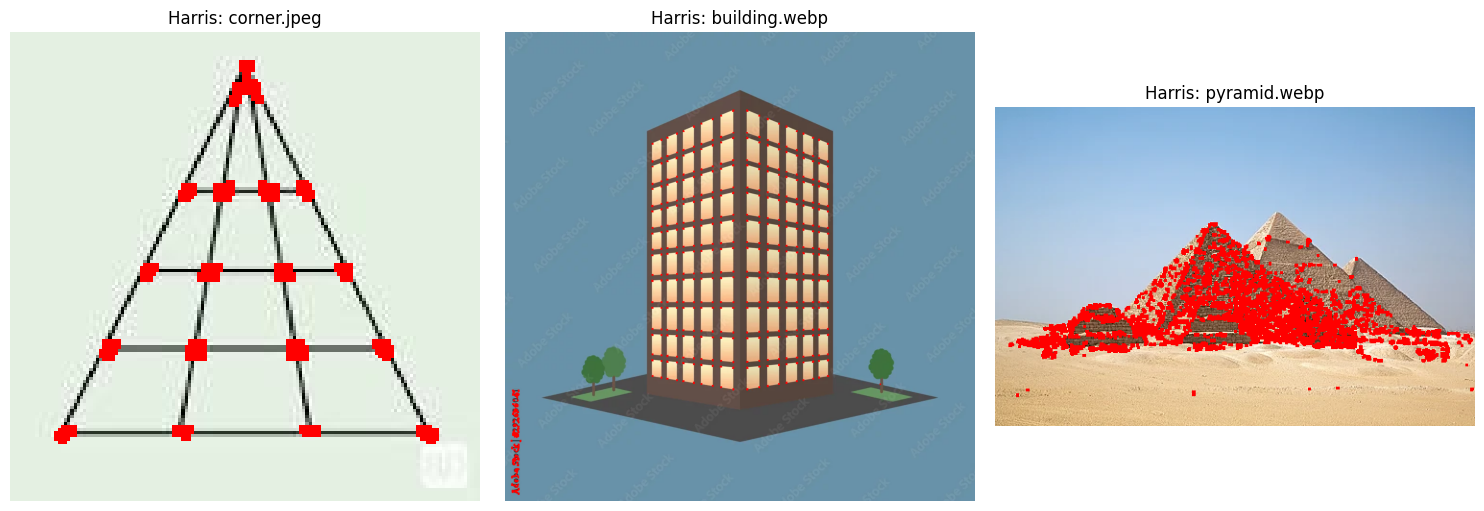

In [9]:
file_list_2 = ['corner.jpeg', 'building.webp', 'pyramid.webp']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, fname in enumerate(file_list_2):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)

    mask = dst > 0.01 * dst.max()
    img[mask] = [0, 0, 255]
    r_values = dst[mask]

    print(f"R values for {fname}: {r_values[:20]}...") # 20 R values

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Harris: {fname}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

3. Hough Line and Circle Transform

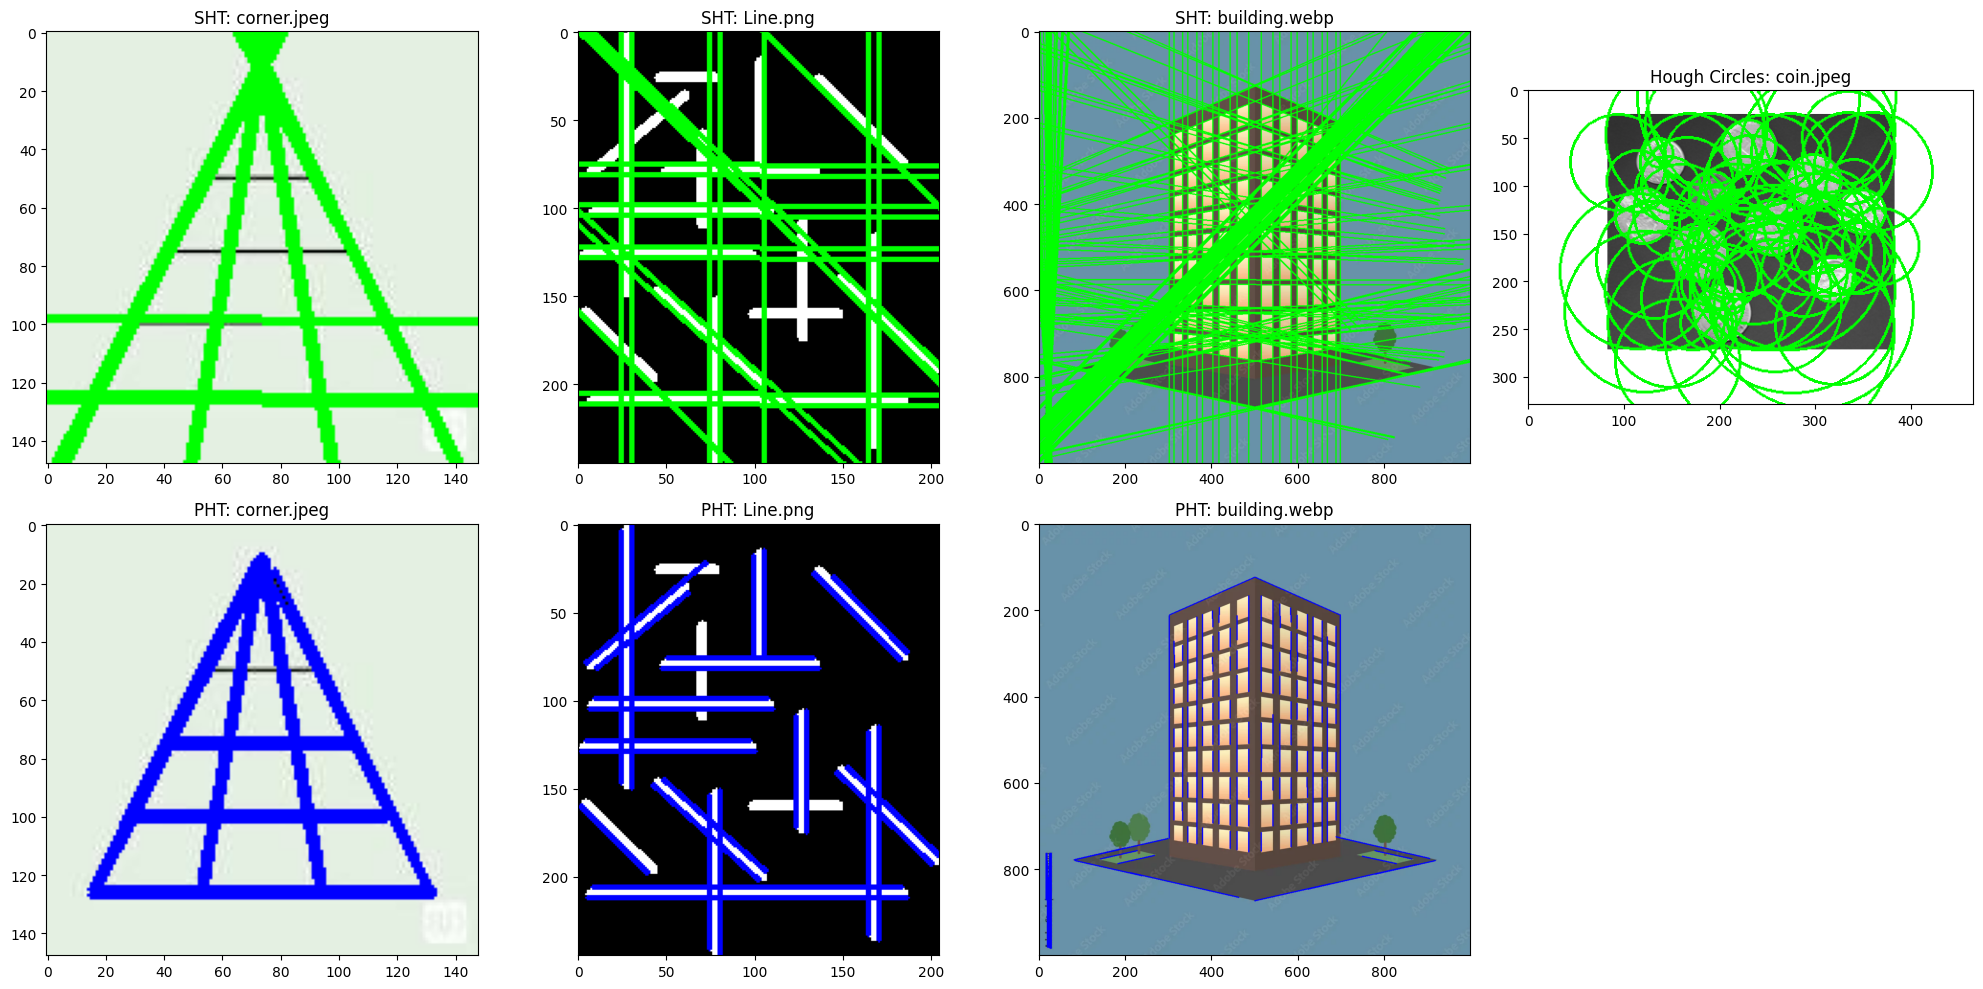

In [12]:
line_files = ['corner.jpeg', 'Line.png', 'building.webp']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, fname in enumerate(line_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    #SHT
    img_sht = img.copy()
    lines_s = cv2.HoughLines(edges, 1, np.pi/180, 70)
    if lines_s is not None:
        for line in lines_s:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a*rho, b*rho
            x1, y1 = int(x0 + 1000*(-b)), int(y0 + 1000*(a))
            x2, y2 = int(x0 - 1000*(-b)), int(y0 - 1000*(a))
            cv2.line(img_sht, (x1, y1), (x2, y2), (0, 255, 0), 2)

    #PHT
    img_pht = img.copy()
    lines_p = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=30, maxLineGap=10)
    if lines_p is not None:
        for line in lines_p:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_pht, (x1, y1), (x2, y2), (255, 0, 0), 2)

    axes[0, i].imshow(cv2.cvtColor(img_sht, cv2.COLOR_BGR2RGB)); axes[0, i].set_title(f"SHT: {fname}")
    axes[1, i].imshow(cv2.cvtColor(img_pht, cv2.COLOR_BGR2RGB)); axes[1, i].set_title(f"PHT: {fname}")

coin_img = cv2.imread('coin.png')
coin_gray = cv2.cvtColor(coin_img, cv2.COLOR_BGR2GRAY)
coin_blur = cv2.medianBlur(coin_gray, 5)
circles = cv2.HoughCircles(coin_blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for c in circles[0, :]:
        cv2.circle(coin_img, (c[0], c[1]), c[2], (0, 255, 0), 2)

axes[0, 3].imshow(cv2.cvtColor(coin_img, cv2.COLOR_BGR2RGB)); axes[0, 3].set_title("Hough Circles: coin.jpeg")
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()